# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [2]:
# Your code here
fraud_detection = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')
fraud_detection.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
fraud_detection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### What is the distribution of the outcome? 

In [4]:
# Your response here
fraud_detection.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [5]:
fraud_detection.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

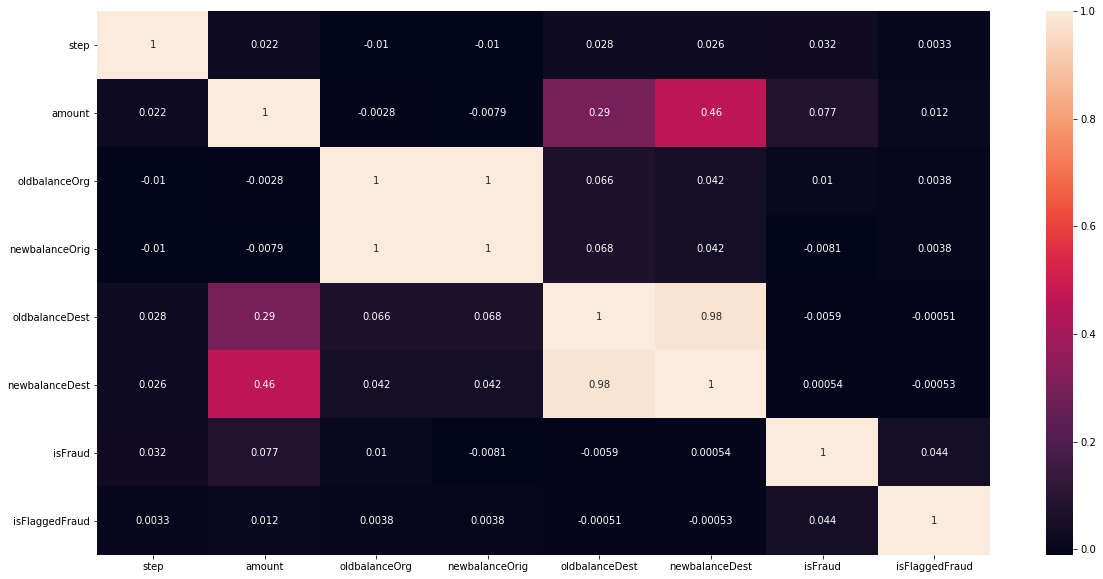

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(fraud_detection.corr(), annot=True)

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [7]:
# Your code here
# Eliminamos las variables con alta correlación 'oldbalanceOrg', 'oldbalanceDest'
fraud_detection.drop(columns=['oldbalanceOrg', 'oldbalanceDest', 'nameDest', 'nameOrig'], inplace=True)
fraud_detection.head()

,step,type,amount,newbalanceOrig,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,160296.36,0.0,0,0
1,1,PAYMENT,1864.28,19384.72,0.0,0,0
2,1,TRANSFER,181.00,0.00,0.0,1,0
3,1,CASH_OUT,181.00,0.00,0.0,1,0
4,1,PAYMENT,11668.14,29885.86,0.0,0,0


In [8]:
fraud_detection_dummy = pd.get_dummies(fraud_detection.type, drop_first=True)
fraud_detection_dummy = pd.merge(fraud_detection, fraud_detection_dummy,left_index=True,right_index=True)
fraud_detection_dummy.drop(columns=['type'], inplace=True)
fraud_detection_dummy.head()

,step,amount,newbalanceOrig,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,160296.36,0.0,0,0,0,0,1,0
1,1,1864.28,19384.72,0.0,0,0,0,0,1,0
2,1,181.00,0.00,0.0,1,0,0,0,0,1
3,1,181.00,0.00,0.0,1,0,1,0,0,0
4,1,11668.14,29885.86,0.0,0,0,0,0,1,0


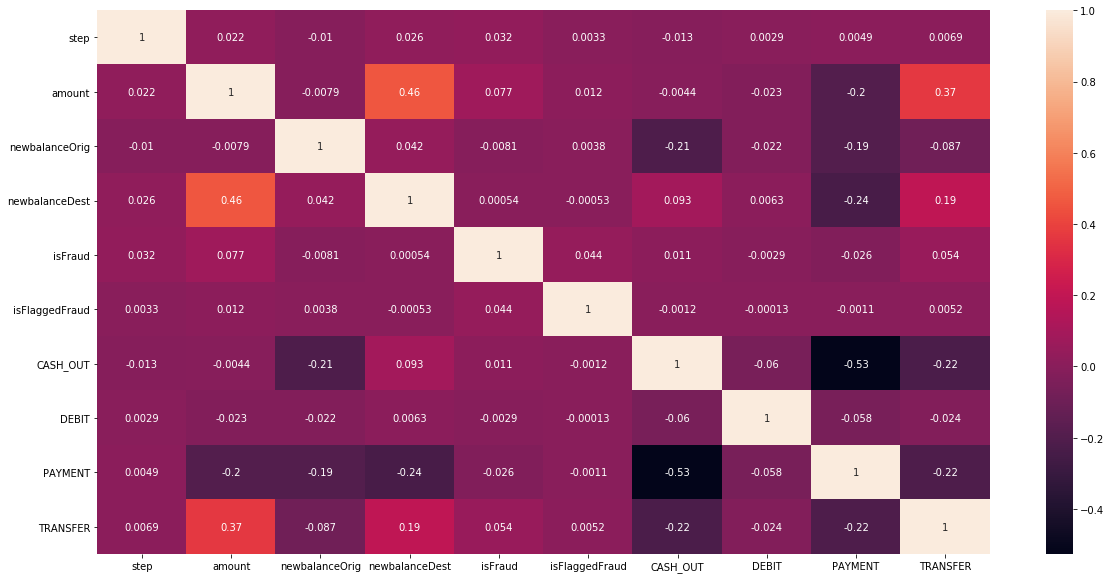

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(fraud_detection_dummy.corr(), annot=True)

### Run a logisitc regression classifier and evaluate its accuracy.

In [10]:
from sklearn.model_selection import train_test_split
X = fraud_detection_dummy[[x for x in fraud_detection_dummy.columns  if x!='isFraud']]
y = fraud_detection_dummy['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
print(f'X_train: {X_train.shape}')
print(f'X_test shape is: {X_test.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'y_test shape is: {y_test.shape}')

X_train: (5090096, 9)
X_test shape is: (1272524, 9)
y_train shape is: (5090096,)
y_test shape is: (1272524,)


In [11]:
# Your code here
from sklearn.linear_model import LogisticRegression
fraud_detection_lg = LogisticRegression()
fraud_detection_lg.fit(X_train, y_train)
y_pred = fraud_detection_lg.predict(X_test)
score_train = fraud_detection_lg.score(X_train, y_train)
score_test  = fraud_detection_lg.score(X_test, y_test)

print(f'Intercept: {fraud_detection_lg.intercept_}')
print(f'Coeficients: {fraud_detection_lg.coef_}')
print(f'Train score: {score_train}')
print(f'Test score: {score_test}')

Intercept: [-0.00014609]
Coeficients: [[-3.57926484e-02  3.64540979e-06 -1.31062946e-05 -4.37431199e-06
   3.73456888e-09 -1.39508864e-05 -6.13507000e-07 -1.30619772e-04
  -3.20770816e-07]]
Train score: 0.9979391351361546
Test score: 0.9979568165315547


### Now pick a model of your choice and evaluate its accuracy.

In [ ]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss]})   # timetaken: to be used for comparison later
    return df_model

# to evaluate baseline models
models = {  'gnb': GaussianNB(),
#             'bnb': BernoulliNB(),
            'mnb': MultinomialNB(),
#             'logit': LogisticRegression(),
            'knn': KNeighborsClassifier(),
            'decisiontree': DecisionTreeClassifier(),
            'randomforest': RandomForestClassifier(),
#             'svc': SVC(probability=True),
#             'linearsvc': LinearSVC()
         }
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.reset_index(inplace=True, drop=True)
models_df

### Which model worked better and how do you know?

In [ ]:
# Your response here
# RandomForestClassifier it's the most accurate but in all the cases the data is unbalanced so it's a problem until 
# we don't undersamppling